In [23]:
from jt_training import get_dataloader, train_one_epoch, evaluate, get_free_gpu

mode_generation = 2
mode = "text_embeddings"

def load_model_old(clip_model_type, clip_pretrained_dataset, n_rel_classes, n_obj_classes):
    from open_clip.jt_ViT_RelClassifier import ViT_RelClassifier
    model = ViT_RelClassifier(n_rel_classes, n_obj_classes, clip_model_type, clip_pretrained_dataset)
    prepocess_function = model.preprocess
    device = get_free_gpu()
    model.to(device)
    print("old model")
    return model, prepocess_function, device
def load_model(clip_model_type, clip_pretrained_dataset, n_rel_classes, n_obj_classes, n_attr_classes, shallow=True, input_mode="text_embeddings", with_object_heads=False):
    if mode_generation==2:
        from open_clip.jt_ViT_RelClassifier_lightning import ViT_RelClassifier
    else:
        from open_clip.jt_ViT_RelClassifier_lightning_old import ViT_RelClassifier
    model = ViT_RelClassifier(n_rel_classes, n_obj_classes, n_attr_classes, clip_model_type, clip_pretrained_dataset, shallow=shallow, mode=input_mode, with_object_heads=with_object_heads)
    prepocess_function = model.preprocess
    device = get_free_gpu(min_mem=20000)
    print(f"Using device {device}")
    model.to(device)
    return model, prepocess_function, device

In [26]:
import torch
clip_model_type = 'ViT-L-14' # 'ViT-L-14' #'ViT-B/32'
clip_pretrained_dataset = 'laion2b_s32b_b82k' # 'laion2b_s32b_b82k' #'laion400m_e32'
image_dir = "/local/home/jthomm/GraphCLIP/datasets/visual_genome/raw/VG/"
metadata_path = "/local/home/jthomm/GraphCLIP/datasets/visual_genome/processed/"

if mode_generation == 0:
    model, prepocess_function, device = load_model_old(clip_model_type, clip_pretrained_dataset, 100, 200)
    model.load_state_dict(torch.load("/local/home/jthomm/GraphCLIP/experiments/2023-04-16/vision_transformer_0/checkpoints/best_rel_model.pt"))
else:
    model, prepocess_function, device = load_model(clip_model_type, clip_pretrained_dataset, 100, 200, 100, with_object_heads=True)
    # loaded = torch.load("/local/home/jthomm/GraphCLIP/experiments/2023-05-05/vision_transformer_12/best_rel_model.ckpt")
    # loaded = torch.load("/local/home/jthomm/GraphCLIP/experiments/2023-05-09/vision_transformer_5/best_rel_model.ckpt", map_location=device)

    # new two ViT/B32 models:
    # no attribute wighting
    # loaded = torch.load("/local/home/jthomm/GraphCLIP/experiments/2023-05-22/vision_transformer_8/best_rel_model.ckpt", map_location=device)
    # attribute wighting
    # loaded = torch.load("/local/home/jthomm/GraphsCLIP/experiments/2023-05-22/vision_transformer_7/best_rel_model.ckpt", map_location=device)

    # increased learning rates and more epochs
    # loaded = torch.load("/local/home/jthomm/GraphCLIP/experiments/2023-05-23/vision_transformer_4/best_rel_model.ckpt", map_location=device)
    # loaded = torch.load("/local/home/jthomm/GraphCLIP/experiments/2023-05-23/vision_transformer_5/best_rel_model.ckpt", map_location=device)

    # loaded = torch.load("/local/home/jthomm/GraphCLIP/experiments/2023-05-24/vision_transformer_0/best_rel_model.ckpt", map_location=device)

    # loaded = torch.load('/local/home/jthomm/GraphCLIP/experiments/2023-05-27/vision_transformer_39/model_epoch-v8.ckpt', map_location=torch.device('cpu'))
    loaded = torch.load('/local/home/jthomm/GraphCLIP/experiments/2023-06-24/vision_transformer_8/model_epoch-v9.ckpt', map_location= device)
    print(loaded.keys())
    model.load_state_dict(loaded['state_dict'])
# dataloader_train, dataloader_val = get_dataloader(prepocess_function,metadata_path,image_dir, testing_only=False)

Using text embeddings as input to the model.
Using device cuda:4
dict_keys(['epoch', 'global_step', 'pytorch-lightning_version', 'state_dict', 'loops', 'callbacks', 'optimizer_states', 'lr_schedulers', 'hparams_name', 'hyper_parameters', 'datamodule_hparams_name', 'datamodule_hyper_parameters'])


In [27]:
### load the first batch and show the predictions
# import torch
# import matplotlib.pyplot as plt
# model.eval()
# for (inputs, bounding_boxes, lrels, lobj1s, lobj2s) in dataloader_val:
#     rel, obj_1, obj_2 = model(inputs.to(device), bounding_boxes.to(device))
#     _, rel_preds = torch.max(rel, 1)
#     _, obj_1_preds = torch.max(obj_1, 1)
#     _, obj_2_preds = torch.max(obj_2, 1)
#     print("relationship predictions:", rel_preds)
#     print("object 1 predictions:", obj_1_preds)
#     print("object 2 predictions:", obj_2_preds)
#     break

the model doesn't always predict a constant which is very good.

In [46]:
from jt_training import get_realistic_graphs_dataset_ViT_relationships
dataset_orig, dataset_adv, list_to_iterate = get_realistic_graphs_dataset_ViT_relationships(prepocess_function, image_dir, mode=mode, version='v2')
print(len(list_to_iterate))

Filtered relationships loaded from file
Filtered objects loaded from file
Filtered attributes loaded from file
Filtered objects loaded from file
Filtered relationships loaded from file
Filtered objects loaded from file
Filtered attributes loaded from file
Filtered objects loaded from file
63


In [52]:
import random
import PIL
from tqdm import tqdm
correct = 0
total = 0
wrong_samples = []
for d in tqdm(list_to_iterate):
    original_graph = d['original_graph']
    adv_graph = d['adv_graph']
    changed_edge = d['changed_edge']
    image_id = original_graph.image_id
    if mode_generation == 0:
        inputs, bounding_boxes, rel_label, obj1_label, obj2_label,_,_,_ = dataset_orig.getitem_from_id_edge(image_id, changed_edge)
        inputs2,_, rel_label_adv, obj1_label_adv, obj2_label_adv,_,_,_ = dataset_adv.getitem_from_id_edge(image_id, changed_edge)
        assert (inputs == inputs2).all()
    elif mode_generation >= 1:
        image, full_text_clip_embd, rel_label, obj1_label, obj2_label, attr1_label, attr2_label, rel_mask, attr1_mask, attr2_mask = dataset_orig.getitem_from_id_edge(image_id, changed_edge, mode=mode)
        image2, _, rel_label_adv, obj1_label_adv, obj2_label_adv, attr1_label_adv, attr2_label_adv, rel_mask_adv, attr1_mask_adv, attr2_mask_adv = dataset_adv.getitem_from_id_edge(image_id, changed_edge, mode=mode)
        assert (image == image2).all()
    # print("original relationship label:", rel_label)
    # print("adversarial relationship label:", rel_label_adv)
    if mode_generation == 0:
        rel, obj_1, obj_2 = model(inputs.unsqueeze(0).to(device), bounding_boxes.unsqueeze(0).to(device))
        rel_adv, obj_1_adv, obj_2_adv = model(inputs.unsqueeze(0).to(device), bounding_boxes.unsqueeze(0).to(device))
    elif mode_generation == 1:
        # print(full_text_clip_embd.shape)
        rel, obj1, obj2, attr = model(image.unsqueeze(0).to(device), full_text_clip_embd.unsqueeze(0).to(device))
        rel_adv, obj1_adv, obj2_adv, attr_adv = model(image2.unsqueeze(0).to(device), full_text_clip_embd.unsqueeze(0).to(device))
    elif mode_generation == 2:
        rel, obj1, obj2, attr1, attr2 = model(image.unsqueeze(0).to(device), full_text_clip_embd.unsqueeze(0).to(device))
        rel_adv, obj1_adv, obj2_adv, attr1_adv, attr2_adv = model(image2.unsqueeze(0).to(device), full_text_clip_embd.unsqueeze(0).to(device))
    original_rel_confidence = rel[0][rel_label].item()
    adversarial_rel_confidence = rel_adv[0][rel_label_adv].item()
    if original_rel_confidence > adversarial_rel_confidence:
        correct += 1
    else:
        rel_name_dict = dataset_orig.rel_classes # a dict with the relationship names as keys and the ids as values
        rel_name = [key for key, value in rel_name_dict.items() if value == rel_label][0]
        rel_name_adv = [key for key, value in rel_name_dict.items() if value == rel_label_adv][0]
        print("orig rel:", rel_name, "adv rel:", rel_name_adv, "orig conf:", original_rel_confidence, "adv conf:", adversarial_rel_confidence)
        wrong_samples.append((d, original_rel_confidence, adversarial_rel_confidence))
    total += 1
    # print("original relationship confidence:", original_rel_confidence)
    # print("adversarial relationship confidence:", adversarial_rel_confidence)
    # break
print("accuracy:", correct/total)

 10%|▉         | 6/63 [00:01<00:12,  4.73it/s]

orig rel: beside adv rel: on top of orig conf: -2.2842977046966553 adv conf: 0.2320728898048401


 13%|█▎        | 8/63 [00:01<00:11,  4.78it/s]

orig rel: laying on adv rel: sitting on orig conf: 1.775688886642456 adv conf: 10.621611595153809


 14%|█▍        | 9/63 [00:01<00:11,  4.79it/s]

orig rel: near adv rel: on orig conf: -0.5127955079078674 adv conf: 4.978176593780518


 27%|██▋       | 17/63 [00:03<00:09,  4.88it/s]

orig rel: behind adv rel: next to orig conf: 4.015420913696289 adv conf: 4.371762752532959


 33%|███▎      | 21/63 [00:04<00:08,  4.80it/s]

orig rel: standing next to adv rel: above orig conf: -3.3525338172912598 adv conf: -1.6477839946746826


 37%|███▋      | 23/63 [00:04<00:08,  4.82it/s]

orig rel: near adv rel: next to orig conf: 2.934312343597412 adv conf: 3.0539252758026123


 41%|████▏     | 26/63 [00:05<00:07,  4.77it/s]

orig rel: above adv rel: in front of orig conf: 5.592985153198242 adv conf: 6.696796417236328


 62%|██████▏   | 39/63 [00:08<00:04,  4.94it/s]

orig rel: on adv rel: in orig conf: 7.630425930023193 adv conf: 8.229357719421387


 70%|██████▉   | 44/63 [00:09<00:03,  5.81it/s]

orig rel: beside adv rel: behind orig conf: -4.233471870422363 adv conf: -1.02646803855896
orig rel: in front of adv rel: on orig conf: 1.4754046201705933 adv conf: 5.868011951446533


 73%|███████▎  | 46/63 [00:09<00:02,  6.33it/s]

orig rel: beside adv rel: behind orig conf: 5.785220623016357 adv conf: 12.796147346496582


 83%|████████▎ | 52/63 [00:09<00:01, 10.87it/s]

orig rel: near adv rel: on orig conf: -0.6293662786483765 adv conf: 9.62534236907959
orig rel: next to adv rel: behind orig conf: 6.123156547546387 adv conf: 10.717297554016113


 89%|████████▉ | 56/63 [00:10<00:00, 14.42it/s]

orig rel: near adv rel: on orig conf: -0.48215872049331665 adv conf: 6.993767261505127
orig rel: next to adv rel: behind orig conf: 7.367210388183594 adv conf: 7.7710795402526855


100%|██████████| 63/63 [00:10<00:00,  6.03it/s]

orig rel: behind adv rel: on orig conf: 3.2087161540985107 adv conf: 9.418498039245605
orig rel: next to adv rel: behind orig conf: 3.08902907371521 adv conf: 7.117892742156982
accuracy: 0.7301587301587301


In [53]:
print("accuracy:", correct/total)
print("n_wrong:", total-correct)

accuracy: 0.7301587301587301
n_wrong: 17


# Plot the mistakes

In [54]:
print(wrong_samples)

[({'original_graph': <networkx.classes.digraph.DiGraph object at 0x7f1f2023f700>, 'adv_graph': <networkx.classes.digraph.DiGraph object at 0x7f1f20329690>, 'changed_edge': (4655468, 4655547), 'adv_predicate': 'on top of'}, -2.2842977046966553, 0.2320728898048401), ({'original_graph': <networkx.classes.digraph.DiGraph object at 0x7f1f2023d7b0>, 'adv_graph': <networkx.classes.digraph.DiGraph object at 0x7f1f2032bc10>, 'changed_edge': (469020, 469021), 'adv_predicate': 'sitting on'}, 1.775688886642456, 10.621611595153809), ({'original_graph': <networkx.classes.digraph.DiGraph object at 0x7f1f2023f760>, 'adv_graph': <networkx.classes.digraph.DiGraph object at 0x7f1f2032aa40>, 'changed_edge': (667952, 667951), 'adv_predicate': 'on'}, -0.5127955079078674, 4.978176593780518), ({'original_graph': <networkx.classes.digraph.DiGraph object at 0x7f1f2023f7f0>, 'adv_graph': <networkx.classes.digraph.DiGraph object at 0x7f1f201020b0>, 'changed_edge': (2609880, 2609881), 'adv_predicate': 'next to'}, 

2334311
people  -  wall
original relationship: beside confidence: -2.2842977046966553
adversarial relationship: on top of confidence: 0.2320728898048401


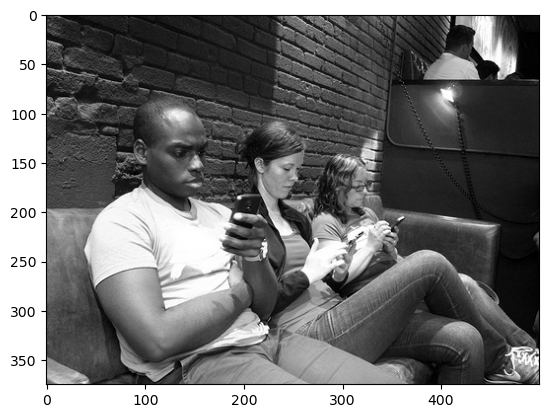

2393892
man  -  seat
original relationship: laying on confidence: 1.775688886642456
adversarial relationship: sitting on confidence: 10.621611595153809


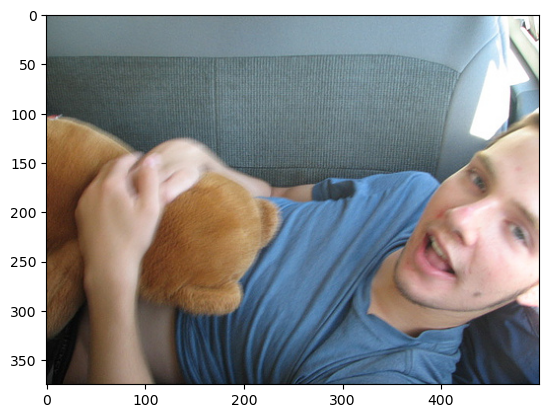

2393004
trees  -  road
original relationship: near confidence: -0.5127955079078674
adversarial relationship: on confidence: 4.978176593780518


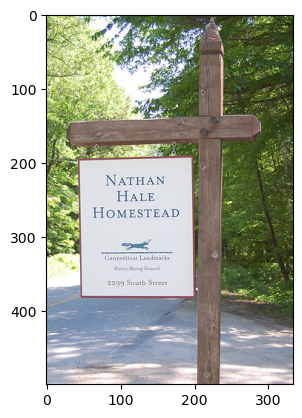

2372661
grass  -  bus
original relationship: behind confidence: 4.015420913696289
adversarial relationship: next to confidence: 4.371762752532959


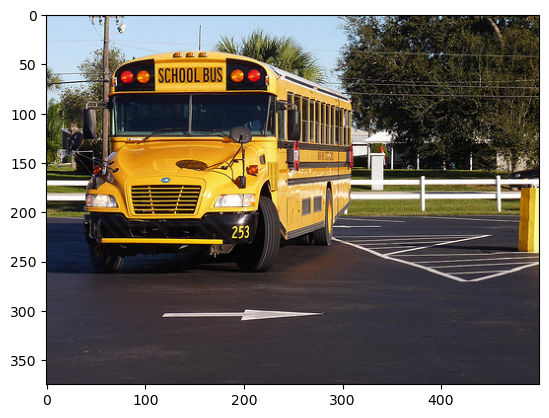

2321841
woman  -  couch
original relationship: standing next to confidence: -3.3525338172912598
adversarial relationship: above confidence: -1.6477839946746826


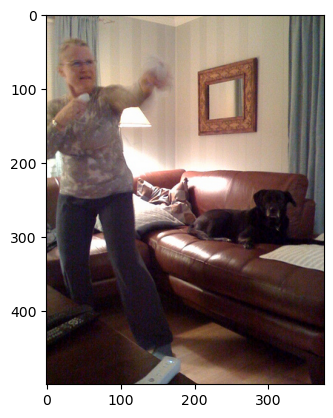

2328306
plant  -  bench
original relationship: near confidence: 2.934312343597412
adversarial relationship: next to confidence: 3.0539252758026123


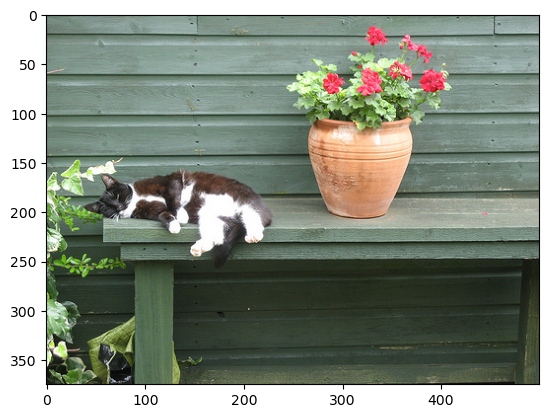

2395196
grass  -  bench
original relationship: above confidence: 5.592985153198242
adversarial relationship: in front of confidence: 6.696796417236328


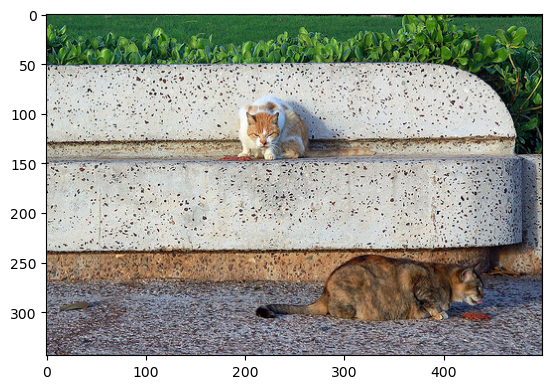

2354003
water  -  glass
original relationship: on confidence: 7.630425930023193
adversarial relationship: in confidence: 8.229357719421387


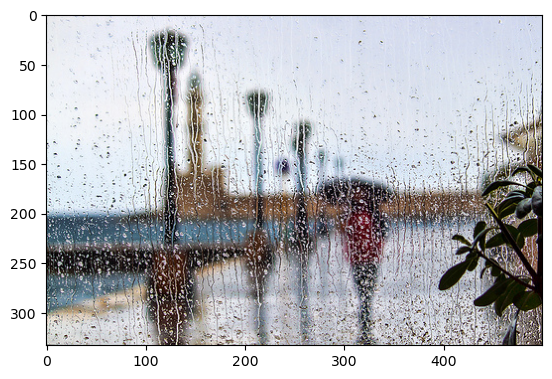

2384424
dog  -  bike
original relationship: beside confidence: -4.233471870422363
adversarial relationship: behind confidence: -1.02646803855896


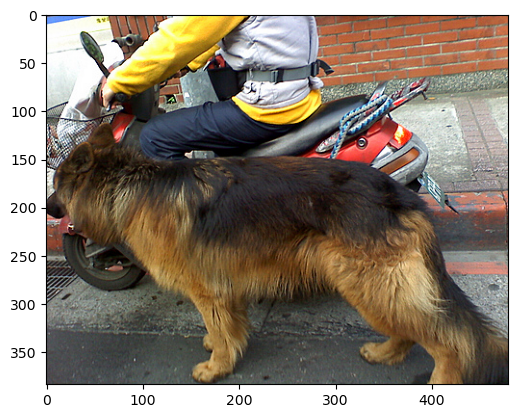

2400515
bush  -  clock
original relationship: in front of confidence: 1.4754046201705933
adversarial relationship: on confidence: 5.868011951446533


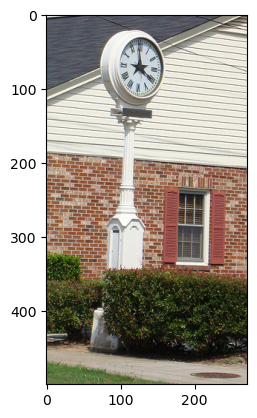

2361236
bush  -  clock
original relationship: beside confidence: 5.785220623016357
adversarial relationship: behind confidence: 12.796147346496582


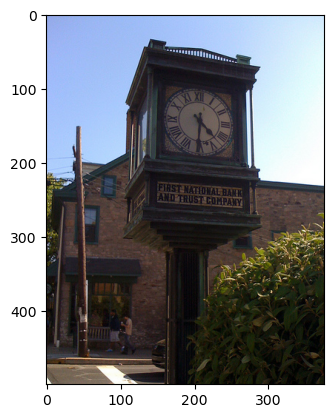

2377356
woman  -  bus
original relationship: near confidence: -0.6293662786483765
adversarial relationship: on confidence: 9.62534236907959


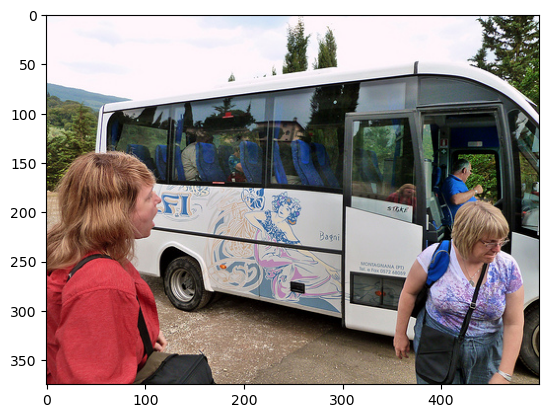

2386031
pot  -  dog
original relationship: next to confidence: 6.123156547546387
adversarial relationship: behind confidence: 10.717297554016113


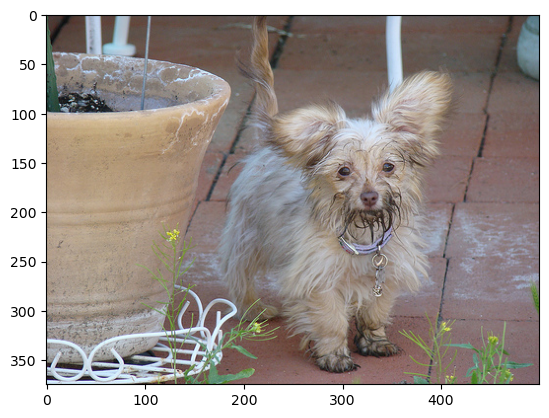

2356554
dog  -  motorcycle
original relationship: near confidence: -0.48215872049331665
adversarial relationship: on confidence: 6.993767261505127


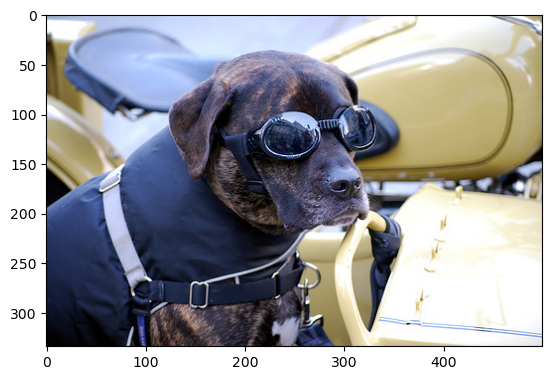

2371105
door  -  toilet
original relationship: next to confidence: 7.367210388183594
adversarial relationship: behind confidence: 7.7710795402526855


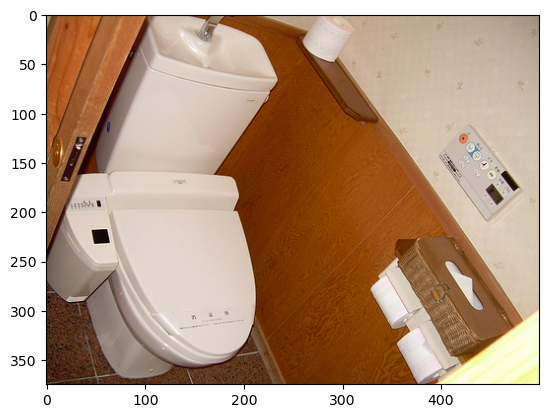

2317779
house  -  field
original relationship: behind confidence: 3.2087161540985107
adversarial relationship: on confidence: 9.418498039245605


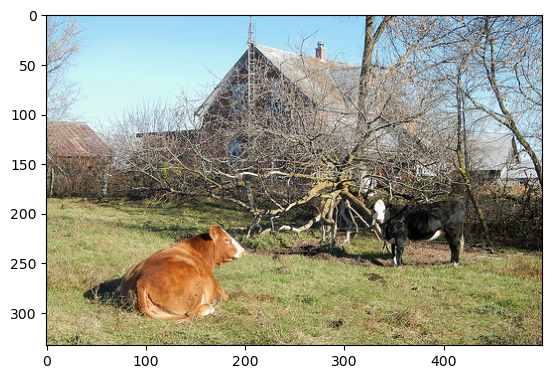

2375277
fence  -  people
original relationship: next to confidence: 3.08902907371521
adversarial relationship: behind confidence: 7.117892742156982


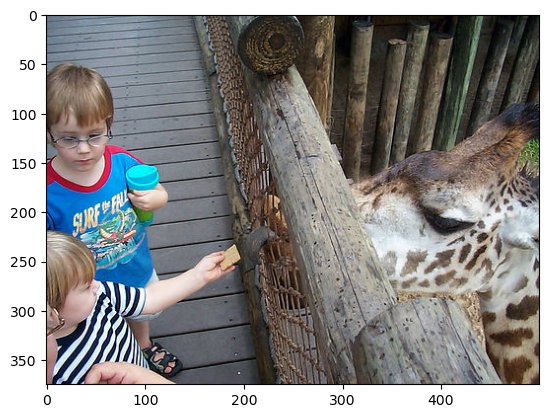

In [55]:
from PIL import Image
IMAGE_DIR = '../datasets/visual_genome/raw/'
def get_image(image_id: int):
    try:
        image = Image.open(IMAGE_DIR + "VG/" + str(image_id) + '.jpg')
        return image
    except:
        pass
    try:
        image = Image.open(IMAGE_DIR + "VG_100K/" + str(image_id) + '.jpg')
        return image
    except:
        pass
    try:
        image = Image.open(IMAGE_DIR + "VG_100K_2/" + str(image_id) + '.jpg')
        return image
    except:
        raise Exception(f"Could not find image with id {image_id}")
import matplotlib.pyplot as plt
for d, orig_conf, adv_conf in wrong_samples:
    original_graph = d['original_graph']
    adv_graph = d['adv_graph']
    changed_edge = d['changed_edge']
    image_id = original_graph.image_id
    print(image_id)
    obj1_name = original_graph.nodes[changed_edge[0]]['name']
    obj2_name = original_graph.nodes[changed_edge[1]]['name']
    print(obj1_name, " - ", obj2_name)
    assert obj1_name == adv_graph.nodes[changed_edge[0]]['name']
    assert obj2_name == adv_graph.nodes[changed_edge[1]]['name']
    assert len(original_graph.nodes) == len(adv_graph.nodes)
    print("original relationship:", original_graph.edges[changed_edge]['predicate'], "confidence:", orig_conf)
    print("adversarial relationship:", adv_graph.edges[changed_edge]['predicate'], "confidence:", adv_conf)

    # plot the image
    image = get_image(original_graph.image_id)
    plt.imshow(image)
    plt.show()

## Check how many samples don't have any attribute

In [3]:
dataloader_train, dataloader_val = get_dataloader(prepocess_function,metadata_path,image_dir, testing_only=False)

Loading filtered graphs...
Done loading filtered graphs.
Filtered relationships loaded from file
Filtered objects loaded from file
Filtered attributes loaded from file
Filtered relationships loaded from file
Filtered objects loaded from file
Filtered attributes loaded from file


In [9]:
import numpy as np
from tqdm import tqdm
how_many_attributes = np.zeros(100)
for batch in tqdm(dataloader_val):
    inputs, bounding_boxes, lrels, lobj1s, lobj2s, lattr, rel_mask = batch
    for sample in range(len(lrels)):
        attr = lattr[sample]
        how_many_attributes[int(torch.sum(attr).item())] += 1

100%|██████████| 3025/3025 [06:18<00:00,  8.00it/s]


In [13]:
how_many_attributes = how_many_attributes[:np.nonzero(how_many_attributes)[0][-1]+1]

[9.5836e+04 7.0312e+04 1.8396e+04 5.8270e+03 2.1750e+03 7.0300e+02
 2.2100e+02 3.7000e+01 3.5000e+01 1.0000e+00]
[4.95166449e-01 3.63288778e-01 9.50486455e-02 3.01070046e-02
 1.12378128e-02 3.63226776e-03 1.14186512e-03 1.91171988e-04
 1.80838367e-04 5.16681048e-06]


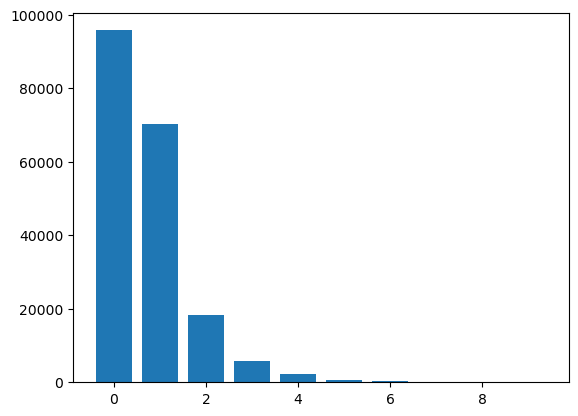

In [15]:
import matplotlib.pyplot as plt
# cut off trailing 0
how_many_attributes2 = how_many_attributes[:np.nonzero(how_many_attributes)[0][-1]+1]
print(how_many_attributes)
print(how_many_attributes/np.sum(how_many_attributes))
# print a histogram of the number of attributes per image
plt.bar(range(len(how_many_attributes)), how_many_attributes)
plt.show()

# Check how well a histogram predictor performs

### preprocess the filtered graphs

In [1]:
import sys
from os.path import dirname, abspath
import torch
d = abspath(dirname('../'))
print(d)
sys.path.append(d)
import random
import PIL
from tqdm import tqdm
from datasets.VG_graphs import get_realistic_graphs_dataset

/local/home/jthomm/GraphCLIP


In [2]:
filtered_graphs_path = "/local/home/jthomm/GraphCLIP/datasets/visual_genome/processed/"
filtered_graphs = filtered_graphs = torch.load(filtered_graphs_path + "filtered_graphs.pt")

In [24]:
list_to_iterate = get_realistic_graphs_dataset('v2')
ids_in_adv = [l['original_graph'].image_id for l in list_to_iterate]

In [25]:
from tqdm import tqdm

histogram = {}
for graph in tqdm(filtered_graphs):
    if graph.image_id in ids_in_adv:
        continue
    for edge in graph.edges:
        key = graph.nodes[edge[0]]['name'] + " " + graph.nodes[edge[1]]['name']
        if key not in histogram:
            histogram[key] = [graph.edges[edge]['predicate']]
        else:
            histogram[key].append(graph.edges[edge]['predicate'])
# only keep the most common predicate per edge
for key in histogram:
    histogram[key] = histogram[key].count # max(set(histogram[key]), key=histogram[key].count)

100%|██████████| 97216/97216 [00:01<00:00, 53082.75it/s]


In [26]:
correct = 0
total = 0
predicates = ['on', 'has', 'in', 'of', 'wearing', 'with', 'behind', 'holding', 'on a', 'near', 'on top of', 'next to', 'has a', 'under', 'of a', 'by', 'above', 'wears', 'in front of', 'sitting on', 'on side of', 'attached to', 'wearing a', 'in a', 'over', 'are on', 'at', 'for', 'around', 'beside', 'standing on', 'riding', 'standing in', 'inside', 'have', 'hanging on', 'walking on', 'on front of', 'are in', 'hanging from', 'carrying', 'holds', 'covering', 'belonging to', 'between', 'along', 'eating', 'and', 'sitting in', 'watching', 'below', 'painted on', 'laying on', 'against', 'playing', 'from', 'inside of', 'looking at', 'with a', 'parked on', 'to', 'has an', 'made of', 'covered in', 'mounted on', 'says', 'growing on', 'across', 'part of', 'on back of', 'flying in', 'outside', 'lying on', 'worn by', 'walking in', 'sitting at', 'printed on', 'underneath', 'crossing', 'beneath', 'full of', 'using', 'filled with', 'hanging in', 'covered with', 'built into', 'standing next to', 'adorning', 'a', 'in middle of', 'flying', 'supporting', 'touching', 'next', 'swinging', 'pulling', 'growing in', 'sitting on top of', 'standing', 'lying on top of']
for d in list_to_iterate:
    original_graph = d['original_graph']
    adv_graph = d['adv_graph']
    changed_edge = d['changed_edge']
    image_id = original_graph.image_id
    edge = original_graph.nodes[changed_edge[0]]['name'] + " " + original_graph.nodes[changed_edge[1]]['name']
    orig_pred = original_graph.edges[changed_edge]['predicate']
    adv_pred = adv_graph.edges[changed_edge]['predicate']
    
    if edge in histogram:
        orig_predicate_confidence = histogram[edge](orig_pred)
        adv_predicate_confidence = histogram[edge](adv_pred)
    if edge not in histogram or (orig_predicate_confidence == 0 and adv_predicate_confidence == 0):
        # set the confidence to -index in the list of predicates
        orig_predicate_confidence = -predicates.index(orig_pred)
        adv_predicate_confidence = -predicates.index(adv_pred)
    if orig_predicate_confidence > adv_predicate_confidence:
        correct += 1
    if orig_predicate_confidence == adv_predicate_confidence:
        correct += 0.5
    total += 1
    # print("original relationship confidence:", original_rel_confidence)
    # print("adversarial relationship confidence:", adversarial_rel_confidence)
    # break
print("accuracy:", correct/total)


accuracy: 0.6666666666666666
